In [1]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from shapely import geometry, ops
from shapely.geometry import MultiLineString, LineString, Point
import os

import time

In [4]:
%%time

# Define the CRS you want to use (e.g., EPSG:4326 for WGS84)
target_crs = 'EPSG:4326'

raw = pd.read_csv("../Data/dumps_motiontag/Storyline.EPFL-Panel.2023-04-24--2023-06-05.csv", sep=';')

staypoints = pd.read_pickle('../Data/dumps_motiontag/storyline_formated/staypoints.pkl').reset_index()
staypoints = gpd.GeoDataFrame(staypoints, geometry="geometry")

CPU times: user 46 s, sys: 7.57 s, total: 53.6 s
Wall time: 55.4 s


In [5]:
raw.head()

,id,user_id,type,started_at,started_at_timezone,finished_at,finished_at_timezone,length,detected_mode,mode,purpose,geometry,confirmed_at,started_on,misdetected_completely,merged,created_at,updated_at,started_at_in_timezone,finished_at_in_timezone,confirmed_at_in_timezone,created_at_in_timezone,updated_at_in_timezone
0,75074f7e-43cf-45ba-85a1-870d3ef09a4e,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Stay,2023-04-30 12:12:28.000,Europe/Zurich,2023-05-01 05:10:22.000,Europe/Zurich,NaN,NaN,NaN,home,0020000001000010e6401a25305bc9b07a40475dbf1402...,2023-05-21 11:26:59.748,2023-04-30,f,f,2023-05-01 15:29:57.981,2023-05-21 11:26:59.748,2023-04-30T14:12:28+02:00,2023-05-01T07:10:22+02:00,2023-05-21T11:26:59Z,2023-05-01T15:29:57Z,2023-05-21T11:26:59Z
1,051d1613-b29a-4598-90d4-2365bf58132b,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Track,2023-05-01 05:10:22.000,Europe/Zurich,2023-05-01 05:16:18.000,Europe/Zurich,4999.0,Mode::Car,Mode::Car,NaN,0020000002000010e600000043401a25305bc9b07a4047...,2023-05-01 19:41:23.435,2023-05-01,f,f,2023-05-01 15:29:57.991,2023-05-02 18:32:09.853,2023-05-01T07:10:22+02:00,2023-05-01T07:16:18+02:00,2023-05-01T19:41:23Z,2023-05-01T15:29:57Z,2023-05-02T18:32:09Z
2,4311fb87-42d1-4950-b330-f06a18459bc1,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Stay,2023-05-01 05:16:18.000,Europe/Zurich,2023-05-01 15:11:05.000,Europe/Zurich,NaN,NaN,NaN,work,0020000001000010e6401a4772606fac60404759fb7c42...,2023-05-01 19:41:19.314,2023-05-01,f,f,2023-05-01 15:29:58.084,2023-05-01 19:41:19.314,2023-05-01T07:16:18+02:00,2023-05-01T17:11:05+02:00,2023-05-01T19:41:19Z,2023-05-01T15:29:58Z,2023-05-01T19:41:19Z
3,92957703-71b4-4ae0-a1d2-3a2862d74a43,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Track,2023-05-01 15:11:05.000,Europe/Zurich,2023-05-01 15:20:08.000,Europe/Zurich,5668.0,Mode::Car,Mode::Car,NaN,0020000002000010e600000069401a4772606fac604047...,2023-05-01 19:41:16.858,2023-05-01,f,f,2023-05-01 15:29:58.093,2023-05-01 19:41:16.858,2023-05-01T17:11:05+02:00,2023-05-01T17:20:08+02:00,2023-05-01T19:41:16Z,2023-05-01T15:29:58Z,2023-05-01T19:41:16Z
4,a274be2e-e5ea-46b2-a32a-32a711dca4e0,000ca786-ebb5-4f48-bfb4-68022b6f7f7b,Stay,2023-05-01 15:20:08.000,Europe/Zurich,2023-05-01 17:41:37.000,Europe/Zurich,NaN,NaN,NaN,home,0020000001000010e6401a2520382ec59040475dc168eb...,2023-05-01 19:41:09.795,2023-05-01,f,f,2023-05-01 19:29:18.431,2023-05-01 19:41:09.795,2023-05-01T17:20:08+02:00,2023-05-01T19:41:37+02:00,2023-05-01T19:41:09Z,2023-05-01T19:29:18Z,2023-05-01T19:41:09Z


In [6]:
staypoints.head()

,id,started_at,finished_at,type,started_at_timezone,purpose,IDNO,geometry
0,75074f7e-43cf-45ba-85a1-870d3ef09a4e,2023-04-30 12:12:28,2023-05-01 05:10:22,Stay,Europe/Zurich,home,CH3181,POINT (6.53632 46.73239)
1,4311fb87-42d1-4950-b330-f06a18459bc1,2023-05-01 05:16:18,2023-05-01 15:11:05,Stay,Europe/Zurich,work,CH3181,POINT (6.56977 46.70299)
2,a274be2e-e5ea-46b2-a32a-32a711dca4e0,2023-05-01 15:20:08,2023-05-01 17:41:37,Stay,Europe/Zurich,home,CH3181,POINT (6.53626 46.73246)
3,11c2c50a-98b8-4608-924e-31644efaed2d,2023-05-01 17:53:05,2023-05-01 19:11:15,Stay,Europe/Zurich,family_friends,CH3181,POINT (6.61113 46.79128)
4,3111307b-2939-4ae3-b6dc-e54ba07ebfa6,2023-05-01 19:24:23,2023-05-02 05:13:13,Stay,Europe/Zurich,home,CH3181,POINT (6.53634 46.73237)


### How much data loss in the first anomaly filtering ?

In [4]:
len(legs) / len(raw[raw.type == 'Track'])

0.997662016577885

### How much data loss with the spatial filters ?

In [5]:
#Level 1 signal loss:
len(legs[legs.low_quality_legs_1 == 1]) / len(legs)

0.05024826335369522

In [6]:
#Level 2 signal loss:
len(legs[legs.low_quality_legs_2 == 1]) / len(legs)

0.07335067236121046

### Temporal filtering

In [7]:
staypoints['started_at'] = pd.to_datetime(staypoints['started_at'], format='%Y-%m-%d %H:%M:%S')
staypoints['date_only'] = staypoints['started_at'].dt.date

In [8]:
staypoints.head(2)

,id,started_at,finished_at,type,started_at_timezone,purpose,IDNO,geometry,date_only
0,75074f7e-43cf-45ba-85a1-870d3ef09a4e,2023-04-30 12:12:28,2023-05-01 05:10:22,Stay,Europe/Zurich,home,CH3181,POINT (6.53632 46.73239),2023-04-30
1,4311fb87-42d1-4950-b330-f06a18459bc1,2023-05-01 05:16:18,2023-05-01 15:11:05,Stay,Europe/Zurich,work,CH3181,POINT (6.56977 46.70299),2023-05-01


In [9]:
# Group by the 'group' column
grouped = staypoints.groupby('IDNO')

# Initialize lists to store group info
groups = []
min_dates = []
max_dates = []
track_durations = []
observations = []
max_gap = []
missing_dates = []

# Iterate over each IDNO ('name') and staypoint df for this specific IDNO ('group')
for name, group in grouped:
    group.drop_duplicates(subset='date_only', keep='last', inplace=True)
    group.set_index('started_at', inplace=True)
    min_date = group.index.min()
    max_date = group.index.max()
    num_observations = len(group)
    track_duration = (max_date - min_date).days + 2
    num_missing_dates = track_duration - num_observations
    consecutive_dates = group.index.to_series().diff().dt.days.fillna(0)
    max_gap_in_days = consecutive_dates[consecutive_dates != 1].max() + 1

    # Print information for the current iteration
    #print("Name:", name)
    #print("Min Date:", min_date)
    #print("Max Date:", max_date)
    #print("Number of Observations:", num_observations)
    #print("Number of Missing Dates:", num_missing_dates)
    #print("Max Gap Between Days:", max_gap_in_days)
    #print("===")

    groups.append(name)
    min_dates.append(min_date)
    max_dates.append(max_date)
    track_durations.append(track_duration)
    observations.append(num_observations)
    missing_dates.append(num_missing_dates)
    max_gap.append(max_gap_in_days)
    
    # Pause and wait for manual progression
    #input("Press Enter to continue to the next iteration...")

# Create a new DataFrame to store the group info
IDNO_info = pd.DataFrame({
    'IDNO': groups,
    'Min Date': min_dates,
    'Max Date': max_dates,
    'Track duration' : track_durations,
    'Number of observation': observations,
    'Missing Dates': missing_dates,
    'Max Gap Between Days': max_gap
})

In [10]:
IDNO_info

,IDNO,Min Date,Max Date,Track duration,Number of observation,Missing Dates,Max Gap Between Days
0,CH01,2023-05-02 18:48:41,2023-06-05 15:44:17,35,35,0,1.0
1,CH02,2023-04-25 18:52:58,2023-06-05 06:35:35,42,37,5,3.0
2,CH10003,2023-04-24 18:45:46,2023-05-31 12:40:27,38,37,1,3.0
3,CH10039,2023-05-03 15:46:05,2023-06-01 13:14:59,30,26,4,3.0
4,CH10068,2023-05-15 16:04:47,2023-06-05 15:20:29,22,22,0,1.0
...,...,...,...,...,...,...,...
2801,FR995,2023-04-25 18:39:15,2023-05-31 07:28:54,37,36,1,3.0
2802,FR996,2023-05-03 18:47:27,2023-06-05 18:21:08,34,15,19,7.0
2803,FR9983,2023-04-24 21:03:59,2023-06-03 11:16:10,41,38,3,3.0
2804,FR9991,2023-05-12 15:53:38,2023-06-05 21:02:26,26,25,1,1.0


<Axes: >

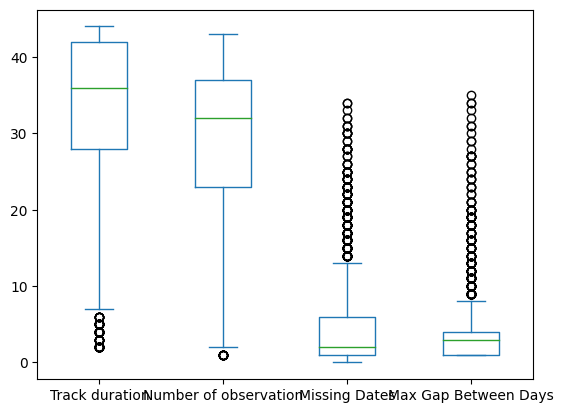

In [11]:
IDNO_info.plot.box()

Max Gap Between Days        Axes(0.125,0.11;0.227941x0.77)
Number of observation    Axes(0.398529,0.11;0.227941x0.77)
Track duration           Axes(0.672059,0.11;0.227941x0.77)
dtype: object

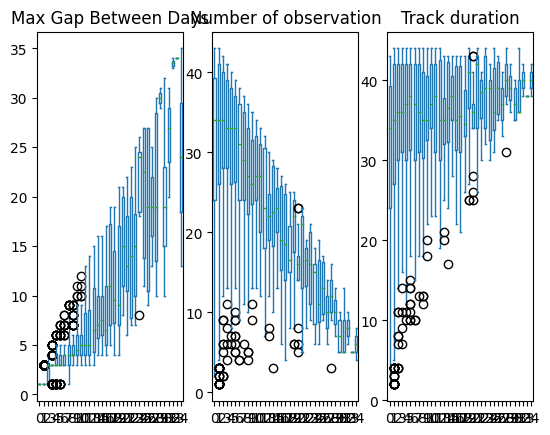

In [12]:
IDNO_info.plot.box(by='Missing Dates')

### Fill in the missing dates to get a continuous timeline

In [13]:
# Convert the date column in datetime format for performing operations
staypoints['date_only'] = pd.to_datetime(staypoints['date_only'], format='%Y-%m-%d')

# Create a date range covering the entire date range for each ID
date_ranges = staypoints.groupby('IDNO')['date_only'].agg(['min', 'max']).reset_index()
date_ranges['started_date'] = date_ranges.apply(lambda row: pd.date_range(row['min'], row['max'], freq='D'), axis=1)

# Create a Cartesian product of IDs and date ranges
cartesian = date_ranges.explode('started_date').reset_index(drop=True)

# Complete the original df with a continuous timeline
staypoints_filled = pd.merge(staypoints, cartesian[['IDNO', 'started_date']], how='outer', left_on=['IDNO', 'date_only'], right_on=['IDNO', 'started_date'])

# Assuming 'staypoints_filled' is your DataFrame
staypoints_filled['started_at'] = staypoints_filled['started_at'].fillna(staypoints_filled['started_date'])
staypoints_filled['finished_at'] = staypoints_filled['finished_at'].fillna(staypoints_filled['started_date'])

# Sort the result DataFrame
staypoints_filled.sort_values(by=['IDNO', 'started_at'], inplace=True)

In [14]:
staypoints_filled[staypoints_filled.IDNO == 'CH02'].head(2)

,id,started_at,finished_at,type,started_at_timezone,purpose,IDNO,geometry,date_only,started_date
267342,60138b4b-a02c-49c7-986b-871c2ba083c6,2023-04-25 05:54:04,2023-04-25 07:52:09,Stay,Europe/Zurich,medical_visit,CH02,POINT (6.62153 46.78970),2023-04-25,2023-04-25
267343,5e064bf6-3e46-47d1-86d8-40c87763ea1d,2023-04-25 07:57:14,2023-04-25 15:04:34,Stay,Europe/Zurich,work,CH02,POINT (6.62152 46.78969),2023-04-25,2023-04-25


### Filter the users with bad tracking records

In [15]:
# Thresholds selected with a qulaitative sensitive analysis
IDNO_info.loc[(IDNO_info['Max Gap Between Days'] > 8) & (IDNO_info['Missing Dates'] > 12) & (IDNO_info['Track duration'] < 31)]

,IDNO,Min Date,Max Date,Track duration,Number of observation,Missing Dates,Max Gap Between Days
154,CH12581,2023-04-25 15:19:52,2023-05-20 19:18:54,27,11,16,11.0
205,CH13323,2023-05-05 21:31:02,2023-05-29 09:26:36,25,5,20,20.0
273,CH14266,2023-05-04 20:09:33,2023-06-02 05:46:31,30,8,22,17.0
392,CH15659,2023-05-02 15:49:55,2023-05-27 13:10:22,26,5,21,16.0
430,CH16369,2023-05-02 20:13:29,2023-05-25 14:57:16,24,7,17,19.0
528,CH17577,2023-05-02 20:05:10,2023-05-25 11:08:53,24,10,14,14.0
650,CH18719,2023-05-11 17:20:34,2023-05-31 16:49:26,21,4,17,18.0
668,CH19024,2023-05-12 19:54:07,2023-05-31 08:51:17,20,7,13,12.0
703,CH19365,2023-04-24 17:47:06,2023-05-20 04:45:27,27,11,16,17.0
758,CH20024,2023-05-03 20:34:58,2023-05-30 07:19:00,28,8,20,21.0


In [16]:
# List of users with bad track record
bad_idno = IDNO_info.loc[(IDNO_info['Max Gap Between Days'] > 5) & (IDNO_info['Missing Dates'] > 7) & (IDNO_info['Track duration'] < 32), 'IDNO'].to_list()

In [17]:
staypoints_filled['scattered_tracking'] = 0
staypoints_filled.loc[staypoints_filled.IDNO.isin(bad_idno), 'scattered_tracking'] = 1

In [18]:
legs['scattered_tracking'] = 0
legs.loc[legs.IDNO.isin(bad_idno), 'scattered_tracking'] = 1

In [19]:
#Temporal filtering loss:
len(staypoints_filled[staypoints_filled.scattered_tracking == 1]) / len(staypoints_filled)

0.009174039494484571

In [20]:
#Temporal filtering loss:
len(legs[legs.scattered_tracking == 1]) / len(legs)

0.007042358905905346

### Add the past and next leg ID to the staypoint df

In [21]:
# Sort 'staypoints' and 'legs' by 'started_at' to ensure data is in chronological order
staypoints_filled.sort_values(by=['IDNO','started_at'], inplace=True)
legs.sort_values(by=['IDNO','started_at'], inplace=True)

In [49]:
result = staypoints_filled.copy()
result['finished_at'] = pd.to_datetime(result['finished_at'], format='%Y-%m-%d %H:%M:%S')
result.sort_values(by=['IDNO','finished_at'], inplace=True)


previous_leg = legs[['IDNO', 'finished_at', 'id', 'mode']].rename(columns={'finished_at': 'started_at', 'id': 'previous_leg_id', 'mode':'previous_mode'})
previous_leg['started_at'] = pd.to_datetime(previous_leg['started_at'], format='%Y-%m-%d %H:%M:%S')
previous_leg.sort_values(by=['IDNO','started_at'], inplace=True)
previous_leg.dropna(inplace=True)

#for idno in result.IDNO.unique():
result = pd.merge(result, previous_leg, on=['IDNO','started_at'], how='left')


# Merge 'staypoints' with 'legs' to find the next leg
next_leg = legs[['IDNO', 'started_at', 'id', 'mode']].rename(columns={'started_at': 'finished_at', 'id': 'next_leg_id', 'mode':'next_mode'})
next_leg['finished_at'] = pd.to_datetime(next_leg['finished_at'], format='%Y-%m-%d %H:%M:%S')
next_leg.sort_values(by=['IDNO','finished_at'], inplace=True)
next_leg.dropna(inplace=True)

#for idno in result.IDNO.unique():
result = pd.merge(result, next_leg, on=['IDNO','finished_at'], how='left')


# Drop unnecessary columns from the result
result.sort_values(by=['IDNO','started_at'], inplace=True)#.drop(['next_leg_started_at', 'past_leg_started_at'], axis=1, inplace=True)

# 
staypoints_filled_completed = result.copy()

### Save to pkl and shapefiles

In [50]:
%%time

# Dump the combined DataFrame to a pickle file
del staypoints_filled_completed['date_only']
staypoints_filled_completed.to_pickle('gps_canton/staypoints_filtered.pkl')

staypoints_filled_completed['started_at'] = staypoints_filled_completed['started_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
staypoints_filled_completed['finished_at'] = staypoints_filled_completed['finished_at'].dt.strftime("%Y-%m-%d %H:%M:%S")
staypoints_filled_completed['started_date'] = staypoints_filled_completed['started_date'].dt.strftime("%Y-%m-%d")

staypoints_filled_completed.rename(columns={'started_at':'start_at', 'finished_at':'finish_at', 
                                        'started_at_timezone':'timezone','started_date':'start_date', 
                                        'scattered_tracking':'scat_track','previous_leg_id':'prev_leg', 'previous_mode':'prev_mode',
                                        'next_leg_id':'next_leg'}).to_crs(crs=target_crs).to_file('gps_canton/shp/staypoints_filtered.shp')

legs.to_pickle('gps_canton/legs_filtered.pkl')
legs.rename(columns = {'started_at': 'start_at', 'finished_at':'finish_at', 'started_at_timezone':'timezone',
                       'detected_mode':'detectmode','low_quality_legs_1':'low_qual_1', 
                       'low_quality_legs_2':'low_qual_2',
                       'scattered_tracking':'scat_track'}).to_crs(crs=target_crs).to_file('gps_canton/shp/legs_filtered.shp')


# List of pickle file names
pickle_files = [
    'legs_FRA_filtered',
    'legs_GG_FRA_filtered',
    'legs_VD_part_1_filtered',
    'legs_VD_part_2_filtered',
    'legs_VD_part_3_filtered',
    'legs_GE_filtered'
]

# We must already have these directory as they were created in the panel_gps_2023_spatial_cleaning which must be launched before this one
input_directory = 'gps_canton'
output_directory = 'gps_canton/shp'

# Load and dump the pickle or shape files

for file in pickle_files:
    df = pd.read_pickle(os.path.join(input_directory, f'{file}.pkl'))
    #Add the column to filter out users with scattered temporal tracking
    df['scattered_tracking'] = 0
    df.loc[df.IDNO.isin(bad_idno), 'scattered_tracking'] = 1
    df.rename(columns = {'started_at': 'start_at', 'finished_at':'finish_at', 'started_at_timezone':'timezone',
       'detected_mode':'detectmode','low_quality_legs_1':'low_qual_1', 
                         'low_quality_legs_2':'low_qual_2', 'scattered_tracking':'scat_track'}, inplace=True)
    df.to_crs(crs=target_crs).to_file(os.path.join(output_directory, f'{file}.shp'))
    df.to_pickle(os.path.join(input_directory, f'{file}.pkl'))

CPU times: user 3min 25s, sys: 24.6 s, total: 3min 50s
Wall time: 4min 8s


### Save without geometry

In [25]:
# Concatenate the dataframes
concatenated_df = pd.concat([staypoints_filled_completed, legs])

# Sort by started_at and IDNO columns
concatenated_df['started_at'] = pd.to_datetime(concatenated_df['started_at'])
sorted_df = concatenated_df.sort_values(by=['IDNO','started_at'])

In [30]:
len(staypoints_filled_completed) + len(legs)

1242337

In [29]:
len(sorted_df)

1242337

In [26]:
sorted_df[['id', 'started_at', 'finished_at', 'type', 'started_at_timezone',
       'purpose', 'IDNO','detected_mode', 'mode']].reset_index(drop=True)

,id,started_at,finished_at,type,started_at_timezone,purpose,IDNO,detected_mode,mode
0,2f587959-8604-44c6-bf28-f19e2bf0913b,2023-05-02 13:04:38,2023-05-02 14:46:42,Stay,Europe/Zurich,unknown,CH01,NaN,NaN
1,aa257257-d427-4a84-81b1-fe3bad92050b,2023-05-02 14:46:42,2023-05-02 15:56:14,Track,Europe/Zurich,NaN,CH01,Mode::Car,Mode::Car
2,7dd02868-9907-4315-85e6-810913107a65,2023-05-02 15:56:14,2023-05-02 18:26:22,Stay,Europe/Zurich,unknown,CH01,NaN,NaN
3,5de690c8-5ee3-46d6-8dce-0733532c6c79,2023-05-02 18:26:22,2023-05-02 18:39:12,Track,Europe/Zurich,NaN,CH01,Mode::Car,Mode::Car
4,a6fa18d2-a25b-4f9d-ba5e-f91bc758774f,2023-05-02 18:39:17,2023-05-02 18:48:41,Track,Europe/Zurich,NaN,CH01,Mode::Walk,Mode::Walk
...,...,...,...,...,...,...,...,...,...
1242332,f37f8129-4b03-480e-8b34-8fec6c3e4c7c,2023-06-05 16:49:44,2023-06-05 17:15:49,Track,Europe/Zurich,NaN,FR9994,Mode::Car,Mode::Car
1242333,061ff169-2c57-4a94-ba78-c1ad4cd1a527,2023-06-05 17:15:49,2023-06-05 17:21:59,Stay,Europe/Paris,wait,FR9994,NaN,NaN
1242334,065281fa-15ff-4801-8680-92bed58cc53a,2023-06-05 18:06:49,2023-06-05 18:12:27,Stay,Europe/Paris,shopping,FR9994,NaN,NaN
1242335,e6d61832-e3f1-48e9-aa5e-b65f92d59eab,2023-06-05 18:12:27,2023-06-05 18:13:34,Track,Europe/Paris,NaN,FR9994,Mode::Walk,Mode::Walk


In [32]:
#sorted_df.to_csv('export_6t/panel_gps_without_geometry.csv.gz', compression='gzip')

KeyboardInterrupt: 

### Some more statistics about gps

In [213]:
staypoints_filled.started_date.min()

Timestamp('2023-04-24 00:00:00')

In [214]:
staypoints_filled.started_date.max()

Timestamp('2023-06-05 00:00:00')

In [208]:
# Extract the date part and group by date
grouped = staypoints_filled.groupby('started_date')['IDNO'].nunique().reset_index()

# Rename the columns for clarity
grouped.columns = ['date', 'count_of_user']

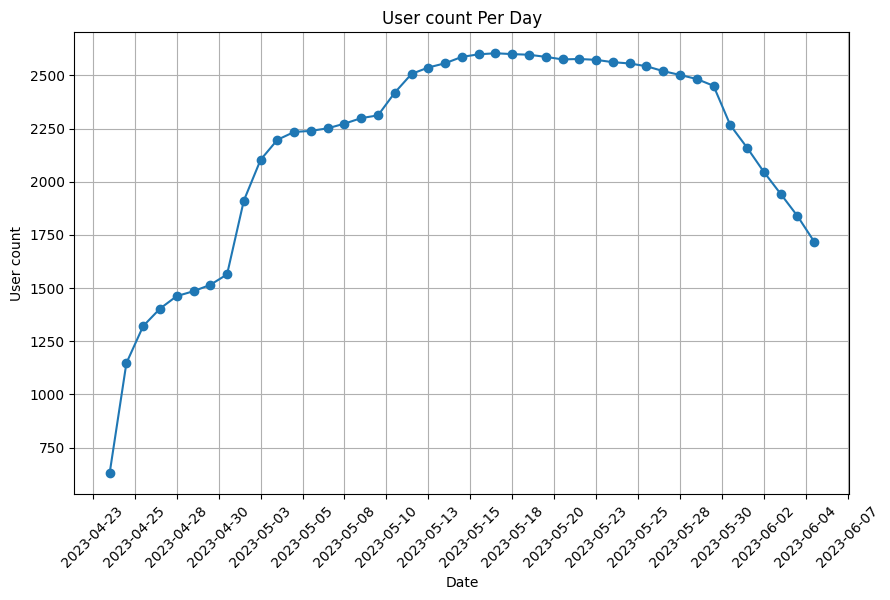

In [212]:
import matplotlib.pyplot as plt

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(grouped['date'], grouped['count_of_user'], marker='o')
plt.xlabel('Date')
plt.ylabel('User count')
plt.title('User count Per Day')

# Adjust the x-axis tick frequency and rotation
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=20))
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

Find boat users for Alexis:

In [228]:
boat_legs = legs.loc[(legs['mode'] == 'Mode::Boat') | (legs['detected_mode'] == 'Mode::Boat'), ['IDNO','id']]
#boat_legs.reset_index(drop=True).to_csv('boat_leg_ids.csv')
boat_legs.head()

,IDNO,id
422286,CH10148,b904151e-32f9-4f11-8c7f-50232b51dd2e
422288,CH10148,d9fd5600-0e56-40ba-9972-41e500b36fe4
422289,CH10148,29192a42-9621-4c2f-94fc-3580584ccf96
174923,CH10361,8ed28202-f7b9-472c-ad21-f164aebfeca5
174928,CH10361,aa9eee84-ccaa-4287-9be7-3d132d869405


In [230]:
legs

,id,started_at,finished_at,type,started_at_timezone,detected_mode,mode,IDNO,geometry,canton_dep,low_quality_legs_1,low_quality_legs_2,scattered_tracking
440589,aa257257-d427-4a84-81b1-fe3bad92050b,2023-05-02 14:46:42,2023-05-02 15:56:14,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,"LINESTRING (6.58428 46.54247, 6.58428 46.54247...",VD,0,0,0
440590,5de690c8-5ee3-46d6-8dce-0733532c6c79,2023-05-02 18:26:22,2023-05-02 18:39:12,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,"LINESTRING (6.94385 46.27073, 6.94385 46.27073...",VD,0,0,0
440591,a6fa18d2-a25b-4f9d-ba5e-f91bc758774f,2023-05-02 18:39:17,2023-05-02 18:48:41,Track,Europe/Zurich,Mode::Walk,Mode::Walk,CH01,"LINESTRING (6.96785 46.32073, 6.96784 46.32073...",VD,0,0,0
440592,4f2b8865-3290-4d4c-826d-7524d2278da9,2023-05-03 04:26:51,2023-05-03 05:13:57,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,"LINESTRING (6.96822 46.31965, 6.96837 46.32017...",VD,0,0,0
440593,c17d2027-28a0-4124-a7e1-2ed227436310,2023-05-03 09:49:49,2023-05-03 09:50:45,Track,Europe/Zurich,Mode::Walk,Mode::Walk,CH01,"LINESTRING (6.58502 46.54596, 6.58491 46.54557...",VD,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39823,485fb233-bf7e-4aed-a98b-ca3d95846d78,2023-06-05 10:50:37,2023-06-05 11:09:14,Track,Europe/Zurich,Mode::Walk,Mode::Walk,FR9994,"LINESTRING (6.14684 46.20418, 6.14684 46.20418...",FRA,0,0,1
39824,a63683dd-8a30-4f5e-9f7c-a75a70ad1fd5,2023-06-05 11:30:27,2023-06-05 11:36:38,Track,Europe/Zurich,Mode::Walk,Mode::Walk,FR9994,"LINESTRING (6.15094 46.20234, 6.14995 46.20324...",FRA,0,0,1
39825,f37f8129-4b03-480e-8b34-8fec6c3e4c7c,2023-06-05 16:49:44,2023-06-05 17:15:49,Track,Europe/Zurich,Mode::Car,Mode::Car,FR9994,"LINESTRING (6.14669 46.20446, 6.14669 46.20446...",FRA,0,0,1
39826,e6d61832-e3f1-48e9-aa5e-b65f92d59eab,2023-06-05 18:12:27,2023-06-05 18:13:34,Track,Europe/Paris,Mode::Walk,Mode::Walk,FR9994,"LINESTRING (6.09565 46.12210, 6.09542 46.12224...",FRA,0,0,1


In [233]:
len(legs.IDNO.unique())

2802

In [239]:
legs.columns

Index(['id', 'started_at', 'finished_at', 'type', 'started_at_timezone',
       'detected_mode', 'mode', 'IDNO', 'geometry', 'canton_dep',
       'low_quality_legs_1', 'low_quality_legs_2', 'scattered_tracking'],
      dtype='object')

In [241]:
legs.head(2)

,id,started_at,finished_at,type,started_at_timezone,detected_mode,mode,IDNO,geometry,canton_dep,low_quality_legs_1,low_quality_legs_2,scattered_tracking
440589,aa257257-d427-4a84-81b1-fe3bad92050b,2023-05-02 14:46:42,2023-05-02 15:56:14,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,"LINESTRING (6.58428 46.54247, 6.58428 46.54247...",VD,0,0,0
440590,5de690c8-5ee3-46d6-8dce-0733532c6c79,2023-05-02 18:26:22,2023-05-02 18:39:12,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,"LINESTRING (6.94385 46.27073, 6.94385 46.27073...",VD,0,0,0


In [240]:
staypoints_filled_completed

,id,started_at,finished_at,type,started_at_timezone,purpose,IDNO,geometry,scattered_tracking,started_date,previous_leg_id,next_leg_id
0,2f587959-8604-44c6-bf28-f19e2bf0913b,2023-05-02,2023-05-02,Stay,Europe/Zurich,unknown,CH01,POINT (6.58428 46.54247),0,2023-05-02,NaN,aa257257-d427-4a84-81b1-fe3bad92050b
1,7dd02868-9907-4315-85e6-810913107a65,2023-05-02,2023-05-02,Stay,Europe/Zurich,unknown,CH01,POINT (6.94385 46.27073),0,2023-05-02,aa257257-d427-4a84-81b1-fe3bad92050b,5de690c8-5ee3-46d6-8dce-0733532c6c79
2,59acb1a8-2a61-4cba-b2ea-cb563e7ae7fa,2023-05-02,2023-05-03,Stay,Europe/Zurich,home,CH01,POINT (6.96822 46.31965),0,2023-05-02,a6fa18d2-a25b-4f9d-ba5e-f91bc758774f,4f2b8865-3290-4d4c-826d-7524d2278da9
3,872eee0c-b72e-4e1f-8a20-f12c5e9ff5a7,2023-05-03,2023-05-03,Stay,Europe/Zurich,wait,CH01,POINT (6.58502 46.54596),0,2023-05-03,4f2b8865-3290-4d4c-826d-7524d2278da9,c17d2027-28a0-4124-a7e1-2ed227436310
4,a6ec5bd7-1c05-4845-830d-2a9ac870b9a0,2023-05-03,2023-05-03,Stay,Europe/Zurich,wait,CH01,POINT (6.58514 46.54561),0,2023-05-03,c17d2027-28a0-4124-a7e1-2ed227436310,6d94f6b6-3081-4188-a4d7-9266b0df566d
...,...,...,...,...,...,...,...,...,...,...,...,...
574090,0ac5e583-3ee2-4a4f-9631-96f062f2be0c,2023-06-05,2023-06-05,Stay,Europe/Zurich,eat,FR9994,POINT (6.14684 46.20418),1,2023-06-05,ce658635-e719-453a-949f-10dc287e3c23,485fb233-bf7e-4aed-a98b-ca3d95846d78
574091,a4a8e0db-8d48-4566-8cd7-1bd38b2e484f,2023-06-05,2023-06-05,Stay,Europe/Zurich,shopping,FR9994,POINT (6.15094 46.20234),1,2023-06-05,485fb233-bf7e-4aed-a98b-ca3d95846d78,a63683dd-8a30-4f5e-9f7c-a75a70ad1fd5
574092,78e868e5-a2f8-4e8e-b548-6db975c6ea13,2023-06-05,2023-06-05,Stay,Europe/Zurich,eat,FR9994,POINT (6.14669 46.20446),1,2023-06-05,a63683dd-8a30-4f5e-9f7c-a75a70ad1fd5,f37f8129-4b03-480e-8b34-8fec6c3e4c7c
574093,061ff169-2c57-4a94-ba78-c1ad4cd1a527,2023-06-05,2023-06-05,Stay,Europe/Paris,wait,FR9994,POINT (6.09524 46.12275),1,2023-06-05,f37f8129-4b03-480e-8b34-8fec6c3e4c7c,NaN


In [237]:
len(legs.started_at_timezone.unique())

80

In [245]:
legs[['IDNO', 'id','low_quality_legs_1', 'low_quality_legs_2','scattered_tracking']].reset_index(drop=True).to_csv('table_of_ID_and_filters.csv')